In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import gc
from sklearn.preprocessing import StandardScaler


class TimeEmbedding(nn.Module):
    """
    Sinusoidal time embedding for continuous time values.
    """
    def __init__(self, embed_dim: int):
        super().__init__()
        self.embed_dim = embed_dim
        
    def forward(self, t: torch.Tensor) -> torch.Tensor:
        # t should be shape (batch_size,) with values in [0, 1]
        device = t.device
        half_dim = self.embed_dim // 2
        emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
        return emb


class TimeSteinScoreNetwork(nn.Module):
    def __init__(self,
                 input_dimension: int,
                 time_embed_dim: int = 32,
                 hidden_dimension: int = 64,
                 number_hidden_layers: int = 3,
                 output_dimension: int = 32,
                 dropout_prob: float = 0.25):
        """
        Time-dependent score network that takes concatenated input [x | time_embedding].

        Args:
            input_dimension: Dimensionality of input data.
            time_embed_dim: Dimension of time embedding.
            hidden_dimension: Size of hidden layers.
            number_hidden_layers: Number of hidden layers.
            output_dimension: Output dimension (should match data dimensionality).
            dropout_prob: Dropout probability.
        """
        super(TimeSteinScoreNetwork, self).__init__()
        
        self.time_embedding = TimeEmbedding(time_embed_dim)
        
        # Input layer takes data + time embedding
        total_input_dim = input_dimension + time_embed_dim
        self.input_layer = nn.Linear(total_input_dim, hidden_dimension)
        self.dropout = nn.Dropout(dropout_prob)

        self.hidden_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dimension, hidden_dimension),
                nn.SELU(),
                nn.Dropout(dropout_prob)
            ) for _ in range(number_hidden_layers)
        ])

        self.output_layer = nn.Linear(hidden_dimension, output_dimension)

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Forward pass with data and time.
        
        Args:
            x: Data tensor of shape (batch_size, input_dimension)
            t: Time tensor of shape (batch_size,) with values in [0, 1]
        """
        # Get time embedding
        t_emb = self.time_embedding(t)
        
        # Concatenate data and time embedding
        x_t = torch.cat([x, t_emb], dim=1)
        
        # Forward through network
        x_t = torch.selu(self.input_layer(x_t))
        x_t = self.dropout(x_t)

        for layer in self.hidden_layers:
            x_t = layer(x_t)

        return self.output_layer(x_t)


def get_vp_noise_schedule(num_steps: int, beta_min: float = 0.1, beta_max: float = 20.0) -> tuple:
    """
    Generate a VP (Variance Preserving) noise schedule.

    Args:
        num_steps: Number of discrete time steps.
        beta_min: Minimum beta (controls early noise).
        beta_max: Maximum beta (controls final noise).

    Returns:
        tuple: (sigma_t, beta_t, alpha_t) - standard deviations, beta values, and alpha values for each time step.
    """
    t = torch.linspace(0., 1., steps=num_steps)
    beta_t = beta_min + t * (beta_max - beta_min)
    log_alpha = -0.5 * torch.cumsum(beta_t * (1.0 / num_steps), dim=0)
    alpha = torch.exp(log_alpha)
    sigma = torch.sqrt(1 - alpha ** 2)
    return sigma, beta_t, alpha


class TimeDependentDiffusionSDE:
    def __init__(self,
                 data: torch.Tensor,
                 input_dimension: int = 2,
                 time_embed_dim: int = 32,
                 hidden_dimension: int = 64,
                 number_hidden_layers: int = 3,
                 output_dimension: int = 2,
                 epochs: int = 2500,
                 lr: float = 1e-3,
                 num_time_steps: int = 1000,
                 dropout_prob: float = 0.25,
                 beta_min: float = 0.1,
                 beta_max: float = 20.0):

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.input_dimension = input_dimension
        self.epochs = epochs
        self.lr = lr
        self.num_time_steps = num_time_steps
        self.beta_min = beta_min
        self.beta_max = beta_max

        # Normalize data
        self.scaler = StandardScaler()
        data_np = data.cpu().numpy()
        normalized_data_np = self.scaler.fit_transform(data_np)
        self.data = torch.tensor(normalized_data_np, dtype=torch.float32).to(self.device)

        # Get noise schedule
        self.sigma_schedule, self.beta_schedule, self.alpha_schedule = get_vp_noise_schedule(
            num_time_steps, beta_min=beta_min, beta_max=beta_max
        )
        self.sigma_schedule = self.sigma_schedule.to(self.device)
        self.beta_schedule = self.beta_schedule.to(self.device)
        self.alpha_schedule = self.alpha_schedule.to(self.device)

        # Initialize time-dependent score network
        self.score_net = TimeSteinScoreNetwork(
            input_dimension=input_dimension,
            time_embed_dim=time_embed_dim,
            hidden_dimension=hidden_dimension,
            number_hidden_layers=number_hidden_layers,
            output_dimension=output_dimension,
            dropout_prob=dropout_prob
        ).to(self.device)

        self.optimizer = optim.Adam(self.score_net.parameters(), lr=self.lr)
        self.criterion = nn.MSELoss()

    def get_sigma_t(self, t: torch.Tensor) -> torch.Tensor:
        """Get sigma values for continuous time t in [0, 1]."""
        # Interpolate sigma values based on continuous time
        t_indices = t * (self.num_time_steps - 1)
        t_floor = torch.floor(t_indices).long().clamp(0, self.num_time_steps - 1)
        t_ceil = torch.ceil(t_indices).long().clamp(0, self.num_time_steps - 1)
        
        alpha = t_indices - t_floor.float()
        sigma_floor = self.sigma_schedule[t_floor]
        sigma_ceil = self.sigma_schedule[t_ceil]
        
        return sigma_floor * (1 - alpha) + sigma_ceil * alpha

    def get_beta_t(self, t: torch.Tensor) -> torch.Tensor:
        """Get beta values for continuous time t in [0, 1]."""
        return self.beta_min + t * (self.beta_max - self.beta_min)

    def fit(self):
        """Train the score network using time-dependent denoising score matching."""
        self.score_net.train()

        for epoch in range(self.epochs):
            self.optimizer.zero_grad()

            # Sample random time steps uniformly from [0, 1]
            batch_size = self.data.size(0)
            t = torch.rand(batch_size, device=self.device)
            
            # Get sigma values for these time steps
            sigmas = self.get_sigma_t(t).view(-1, 1)

            # Add noise to data
            noise = torch.randn_like(self.data)
            noisy_data = self.data + sigmas * noise

            # Compute score prediction using time
            score_pred = self.score_net(noisy_data, t)

            # Score matching objective: predict -noise/sigma
            score_target = -noise / (sigmas + 1e-8)
            loss = self.criterion(score_pred, score_target)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.score_net.parameters(), max_norm=10.0)
            self.optimizer.step()

            if epoch % 100 == 0:
                print(f"[Epoch {epoch}] Loss: {loss.item():.4f}")

    def corrector_step(self, samples: torch.Tensor, t: torch.Tensor,
                       n_steps: int = 1, snr: float = 0.16) -> torch.Tensor:
        """
        Perform Langevin MCMC corrector steps.

        Args:
            samples: Current samples
            t: Current time values
            n_steps: Number of corrector steps
            snr: Signal-to-noise ratio for step size
        """
        sigma = self.get_sigma_t(t).view(-1, 1)
        step_size = 2 * (snr * sigma) ** 2

        for _ in range(n_steps):
            noise = torch.randn_like(samples)

            with torch.no_grad():
                score = self.score_net(samples, t)

            samples = samples + step_size * score + torch.sqrt(2 * step_size) * noise

        return samples

    def generate(self,
                 n_samples: int = 1000,
                 steps: int = 1000,
                 num_corrector_steps: int = 1,
                 batch_size: int = 100,
                 denormalize: bool = True,
                 snr: float = 0.16) -> torch.Tensor:
        """
        Generate samples using PC sampler (Predictor-Corrector) with time-dependent scoring.

        Args:
            n_samples: Number of samples to generate
            steps: Number of discretization steps
            num_corrector_steps: Number of Langevin MCMC steps per iteration
            batch_size: Batch size for generation
            denormalize: Whether to denormalize the generated samples
            snr: Signal-to-noise ratio for corrector steps
        """
        self.score_net.eval()
        all_samples = []

        # Time steps from T=1 to T=0
        time_steps = torch.linspace(1., 0., steps + 1).to(self.device)
        dt = 1.0 / steps

        for batch_start in range(0, n_samples, batch_size):
            batch_end = min(batch_start + batch_size, n_samples)
            current_batch_size = batch_end - batch_start

            # Initialize with pure noise (at t=1)
            samples = torch.randn(current_batch_size, self.input_dimension).to(self.device)
            # Scale by maximum sigma (at t=1)
            max_sigma = self.get_sigma_t(torch.ones(1, device=self.device)).item()
            samples = samples * max_sigma

            with torch.no_grad():
                for i in range(steps):
                    t_current = time_steps[i]
                    t_next = time_steps[i + 1]

                    # Create time tensors for current batch
                    t_batch = t_current.repeat(current_batch_size)
                    
                    # Get beta value for current time
                    beta_t = self.get_beta_t(t_batch)

                    # Compute score at current time
                    score = self.score_net(samples, t_batch)

                    # Predictor step (reverse-time SDE)
                    drift = -0.5 * beta_t.view(-1, 1) * samples
                    diffusion = torch.sqrt(beta_t.view(-1, 1))

                    # Euler-Maruyama step
                    z = torch.randn_like(samples) if i < steps - 1 else torch.zeros_like(samples)
                    samples = samples - dt * (drift + diffusion ** 2 * score) + diffusion * np.sqrt(dt) * z

                    # Corrector step (optional)
                    if num_corrector_steps > 0 and i < steps - 1:
                        t_next_batch = t_next.repeat(current_batch_size)
                        samples = self.corrector_step(samples, t_next_batch, num_corrector_steps, snr)

            all_samples.append(samples.cpu())
            del samples
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        samples = torch.cat(all_samples, dim=0)

        if denormalize:
            samples_np = samples.numpy()
            return torch.tensor(self.scaler.inverse_transform(samples_np), dtype=torch.float32)

        return samples

    def denormalize(self, samples: torch.Tensor) -> torch.Tensor:
        """Denormalize samples to original scale."""
        samples_np = samples.cpu().numpy()
        return torch.tensor(self.scaler.inverse_transform(samples_np), dtype=torch.float32)

    def sample_ode(self,
                   n_samples: int = 1000,
                   steps: int = 1000,
                   batch_size: int = 100,
                   denormalize: bool = True) -> torch.Tensor:
        """
        Generate samples using the probability flow ODE (deterministic sampling).
        
        Args:
            n_samples: Number of samples to generate
            steps: Number of discretization steps
            batch_size: Batch size for generation
            denormalize: Whether to denormalize the generated samples
        """
        self.score_net.eval()
        all_samples = []

        # Time steps from T=1 to T=0
        time_steps = torch.linspace(1., 0., steps + 1).to(self.device)
        dt = 1.0 / steps

        for batch_start in range(0, n_samples, batch_size):
            batch_end = min(batch_start + batch_size, n_samples)
            current_batch_size = batch_end - batch_start

            # Initialize with pure noise (at t=1)
            samples = torch.randn(current_batch_size, self.input_dimension).to(self.device)
            max_sigma = self.get_sigma_t(torch.ones(1, device=self.device)).item()
            samples = samples * max_sigma

            with torch.no_grad():
                for i in range(steps):
                    t_current = time_steps[i]
                    
                    # Create time tensors for current batch
                    t_batch = t_current.repeat(current_batch_size)
                    
                    # Get beta value for current time
                    beta_t = self.get_beta_t(t_batch)

                    # Compute score at current time
                    score = self.score_net(samples, t_batch)

                    # Probability flow ODE (no stochastic term)
                    drift = -0.5 * beta_t.view(-1, 1) * (samples + beta_t.view(-1, 1) * score)
                    
                    # Euler step
                    samples = samples - dt * drift

            all_samples.append(samples.cpu())
            del samples
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        samples = torch.cat(all_samples, dim=0)

        if denormalize:
            samples_np = samples.numpy()
            return torch.tensor(self.scaler.inverse_transform(samples_np), dtype=torch.float32)

        return samples

Training model...
[Epoch 0] Loss: 40.3926
[Epoch 100] Loss: 23.3868
[Epoch 200] Loss: 17.8348
[Epoch 300] Loss: 24.1018
[Epoch 400] Loss: 25.5083
[Epoch 500] Loss: 14.2758
[Epoch 600] Loss: 26.8439
[Epoch 700] Loss: 15.2311
[Epoch 800] Loss: 24.7904
[Epoch 900] Loss: 15.7137
[Epoch 1000] Loss: 12.6122
[Epoch 1100] Loss: 25.6254
[Epoch 1200] Loss: 36.3735
[Epoch 1300] Loss: 24.0656
[Epoch 1400] Loss: 25.4548
[Epoch 1500] Loss: 35.2633
[Epoch 1600] Loss: 27.7669
[Epoch 1700] Loss: 34.6080
[Epoch 1800] Loss: 47.3459
[Epoch 1900] Loss: 16.5429
Generating samples...


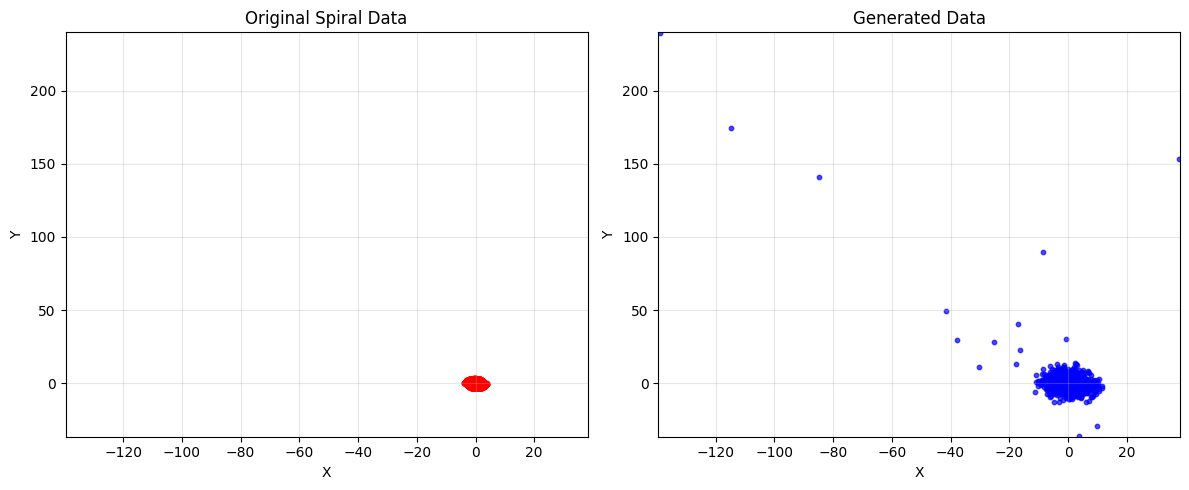

Done!


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def generate_spiral_data(n_samples=2000, noise=0.05):
    """Generate 2D spiral dataset."""
    n_points_per_spiral = n_samples // 2
    
    # First spiral
    t1 = np.linspace(0, 4*np.pi, n_points_per_spiral)
    x1 = t1 * np.cos(t1) * 0.3
    y1 = t1 * np.sin(t1) * 0.3
    
    # Second spiral (offset)
    t2 = np.linspace(0, 4*np.pi, n_points_per_spiral)
    x2 = t2 * np.cos(t2 + np.pi) * 0.3
    y2 = t2 * np.sin(t2 + np.pi) * 0.3
    
    # Combine spirals
    x = np.concatenate([x1, x2])
    y = np.concatenate([y1, y2])
    
    # Add noise
    x += np.random.normal(0, noise, size=x.shape)
    y += np.random.normal(0, noise, size=y.shape)
    
    return np.column_stack([x, y])

# Generate spiral dataset
spiral_data = generate_spiral_data(n_samples=2000, noise=0.05)
spiral_tensor = torch.tensor(spiral_data, dtype=torch.float32)

# Initialize and train model
model = TimeDependentDiffusionSDE(
    data=spiral_tensor,
    input_dimension=2,
    hidden_dimension=64,
    epochs=2000,
    lr=1e-3
)

print("Training model...")
model.fit()

# Generate samples
print("Generating samples...")
generated_samples = model.generate(n_samples=2000, denormalize=True)

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Original data
ax1.scatter(spiral_data[:, 0], spiral_data[:, 1], alpha=0.7, s=10, c='red')
ax1.set_title('Original Spiral Data')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.grid(True, alpha=0.3)

# Generated data
ax2.scatter(generated_samples[:, 0], generated_samples[:, 1], alpha=0.7, s=10, c='blue')
ax2.set_title('Generated Data')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.grid(True, alpha=0.3)

# Set same axis limits
all_data = np.vstack([spiral_data, generated_samples.numpy()])
x_min, x_max = all_data[:, 0].min() - 0.5, all_data[:, 0].max() + 0.5
y_min, y_max = all_data[:, 1].min() - 0.5, all_data[:, 1].max() + 0.5

ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()

print("Done!")